<a href="https://colab.research.google.com/github/shayesteh99/Tehran-Traffic/blob/main/cluster_segments.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import numpy as np
import pandas as pd
import math
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
import matplotlib.pyplot as plt
import torch.nn.functional as F
import torchvision
from tqdm.auto import tqdm, trange
from sklearn.metrics import roc_auc_score
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import r2_score
import xgboost as xgb
from sklearn.neural_network import MLPRegressor
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA

from IPython import display
import torch.backends.cudnn as cudnn
import random

def set_seed(seed):
    cudnn.deterministic = True
    torch.cuda.manual_seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    random.seed(seed)

In [ ]:
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [ ]:
%cd 'gdrive/MyDrive/Neshan2'
%ls

/content/gdrive/.shortcut-targets-by-id/1kb7msLseHDgbNcoeHcAexfHINwu2zRER/Neshan2
check_neighbors_average.ipynb
Classification/
DATA/
find_common_days.ipynb
find_good_segments.ipynb
find_mapped_good_neighors.ipynb
find_neighbors.ipynb
find_shorter_neighbors.ipynb
get_important_good_segment_information.ipynb
get_mapped_good_segment_information.ipynb
GOOD_DATA/
GOOD_IMPORTANT_DATA/
good_important_segment_information.csv
GOOD_MAPPED_DATA/
good_mapped_segment_information.csv
good_segment_information.csv
Important_segment.csv
just_good_neighbors_1000.csv
just_good_neighbors_1500.csv
make_mapped_good_days.ipynb
MAPPED/
mapped_good_data.csv
mapped_good_igraph.ipynb
mapped_good_neighors.csv
mapped_important_good_neighors.csv
mapped_segment.csv
NEIGHBOR/
neighbors_1000.csv
neighbors_750.csv
new_data_df.csv
PP/
Regression/
segment1.txt
segment_locatiion.ipynb
segments_corrected.csv
Shayesteh/
To_verify.ipynb
to_verify_mlpregressor.ipynb
variance.ipynb
vars.txt


In [ ]:
def label_quarter(row):
  date_time = row['date_time']
  time = date_time.split()[1]
  parts = time.split(':')
  hour = int(parts[0])
  minute = int(parts[1])
  return 4*hour + (minute // 15)

In [ ]:
def find_index(intervals, quarter):
  hour = quarter // 4
  for i in range(len(intervals)):
    if hour < intervals[i]:
      index = max(0, i - 1)
      break
  return index

In [ ]:
segment_data = {}
intervals = [0, 5, 10, 15, 20, 24]

In [ ]:
for d in range(1, 20):
  day = str(d)
  day_df = pd.read_csv("GOOD_IMPORTANT_DATA/good_important_segment_day" + day + ".csv")
  day_df['quarter'] = day_df.apply (lambda row: label_quarter(row), axis=1)
  day_df = day_df.drop(columns = ['date_time'])

  for i in range(len(day_df)):
    record = day_df.iloc[i]
    segment_id = record['Unnamed: 0']
    quarter = record['quarter']
    if segment_id not in segment_data:
      segment_data[segment_id] = [[] for i in range(len(intervals) - 1)]
    index = find_index(intervals, quarter)
    segment_data[segment_id][index].append(record['speed'])

In [ ]:
segment_info = []
for s in segment_data:
  seg = [s]
  for i in range(len(intervals) - 1):
    if len(segment_data[s][i]) == 0:
      seg.extend([-1, -1])
      continue
    seg.append(np.mean(segment_data[s][i]))
    seg.append(np.var(segment_data[s][i]))
  segment_info.append(seg)
segment_info = np.array(segment_info)

In [ ]:
columns = ['segment_id']
for i in range(len(intervals) - 1):
  columns.extend(['mean' + str(i+1), 'var' + str(i+1)])
info_df = pd.DataFrame(segment_info, columns = columns)
info_df.to_csv("Shayesteh/dataset/segment_info_" + str(len(intervals) - 1) + ".csv")

In [ ]:
cluster_input = segment_info[:,1:]
seg_ids = segment_info[:,0]
kmeans = KMeans(n_clusters=2, random_state=0).fit(cluster_input)
labels = kmeans.labels_

In [ ]:
unique, counts = np.unique(labels, return_counts=True)
print(dict(zip(unique, counts)))

{0: 18329, 1: 4769}


In [ ]:
indices0 = np.argwhere(labels == 0)
cluster_input0 = cluster_input[indices0]
cluster_input0 = cluster_input0[:, 0, :]
seg_ids0 = seg_ids[indices0]
seg_ids0 = seg_ids0[:,0]
kmeans = KMeans(n_clusters=2, random_state=0).fit(cluster_input0)
labels0 = kmeans.labels_

In [ ]:
unique, counts = np.unique(labels0, return_counts=True)
print(dict(zip(unique, counts)))

{0: 10061, 1: 8268}


In [ ]:
total_labels = labels0
total_input = cluster_input0
total_seg_ids = seg_ids0

indices2 = np.argwhere(labels == 1)
cluster_input2 = cluster_input[indices2]
cluster_input2 = cluster_input2[:, 0, :]
seg_ids2 = seg_ids[indices2]
seg_ids2 = seg_ids2[:,0]

total_seg_ids = np.append(total_seg_ids, seg_ids2, axis = 0)
total_input = np.append(total_input, cluster_input2, axis = 0)
total_labels = np.append(total_labels, np.repeat(2, len(indices2)), axis = 0)
print(total_seg_ids.shape, total_input.shape, total_labels.shape)

(23098,) (23098, 10) (23098,)


In [ ]:
unique, counts = np.unique(total_labels, return_counts=True)
print(dict(zip(unique, counts)))

{0: 10061, 1: 8268, 2: 4769}


<function matplotlib.pyplot.show>

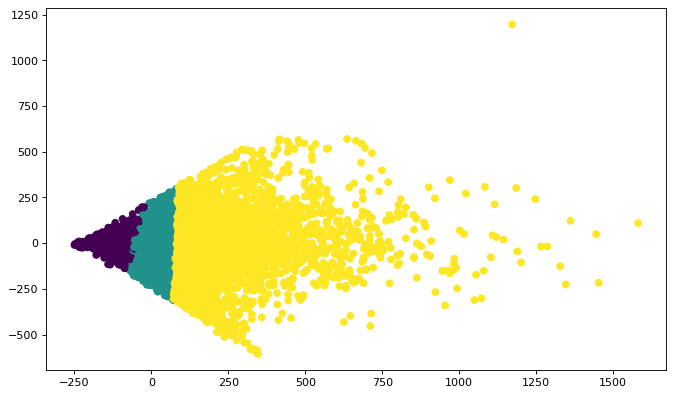

In [ ]:
pca = PCA(n_components=2)
cluster_reduced = pca.fit_transform(total_input)

plt.figure(figsize=(10, 6), dpi=80)
plt.scatter(cluster_reduced[:,0], cluster_reduced[:,1], c = total_labels)
plt.show

In [ ]:
segment_classes = np.c_[total_seg_ids, total_labels]
columns = ['seg_id', 'class']
class_df = pd.DataFrame(segment_classes, columns = columns)
class_df.to_csv("Shayesteh/dataset/segment_classes_3.csv")